In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

sns.set_theme()

In [2]:
### All global variables that would be passed as arguments in a python script
input_csv_file = "/home/nils/Downloads/latency_per_task_buffer.csv"

def remove_duplicate_first_lines_large_file(file_path):
    temp_file_path = file_path + ".temp"
    # Open the original file and a temporary file for writing
    with open(file_path, 'r') as original_file, open(temp_file_path, 'w') as temp_file:
        # Read the first line
        first_line = original_file.readline().strip()

        # Write the first line to the temporary file
        temp_file.write(first_line + '\n')

        # Process the remaining lines
        for line in original_file:
            if line.strip() != first_line:
                temp_file.write(line)

    # Replace the original file with the temporary file
    os.replace(temp_file_path, file_path)


remove_duplicate_first_lines_large_file(input_csv_file)

In [3]:
def load_data():
    df = pd.read_csv(input_csv_file, dtype={'OriginId': int, 'NumberOfInputTuples': int, 'TimeDifference': float,
                                            'Selectivity': int, 'ProviderName': str, 'NumberOfWorkerThreads': int,
                                            'Skewness': float})
    # Remove rows that are equal to the header
    header = df.columns.tolist()
    print(header)

    # Converting some columns to float
    #for col in ['TimeDifference', 'NumberOfInputTuples','Selectivity','NumberOfWorkerThreads','Skewness', 'OriginId']:
    #    df[col] = df[col].astype(float).fillna(0.0)
    #df['LatencyInUS'] = df['EndTimeInUs'] - df['StartTimeInUs']

    #df = df.sort_values(by='SequenceNumber').reset_index(drop=True)
    return df

df = load_data()
df

['OriginId', 'NumberOfInputTuples', 'TimeDifference', 'Selectivity', 'ProviderName', 'NumberOfWorkerThreads', 'Skewness']


,OriginId,NumberOfInputTuples,TimeDifference,Selectivity,ProviderName,NumberOfWorkerThreads,Skewness
0,1,1,7.0,10,Compilation,8,0.0
1,1,1,7.0,10,Compilation,8,0.0
2,1,1,2.0,10,Compilation,8,0.0
3,1,1,5.0,10,Compilation,8,0.0
4,1,1,3.0,10,Compilation,8,0.0
...,...,...,...,...,...,...,...
5246818,10,3000,102.0,90,Compilation,8,0.0
5246819,10,3000,114.0,90,Compilation,8,0.0
5246820,10,3000,504.0,90,Compilation,8,0.0
5246821,10,3000,200.0,90,Compilation,8,0.0


/tmp/ipykernel_100262/3765117030.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NumberOfInputTuples', y='TimeDifference', data=subset, ax=ax, palette="pastel")


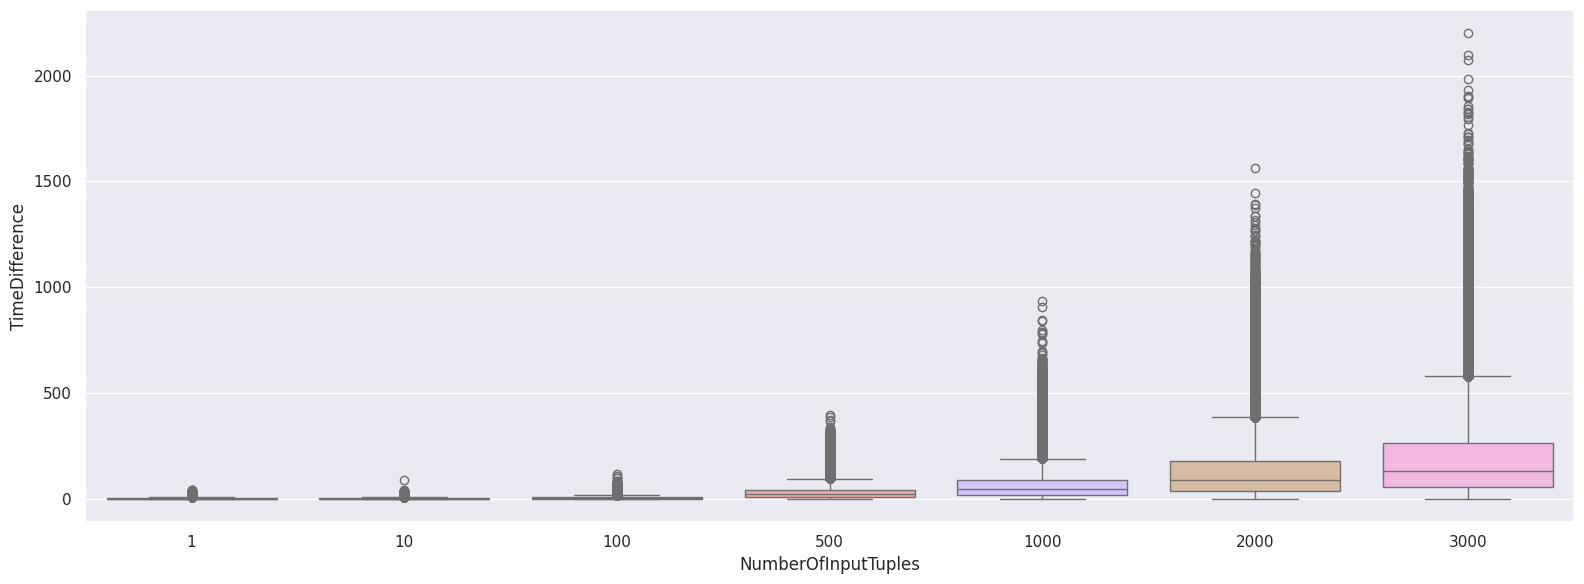

In [4]:
#df = load_data()
df = df[df['ProviderName'] == "Compilation"]

# Sort by 'originid' and 'timestamp'

interesting_param = 'NumberOfWorkerThreads'
unique_params = df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 6), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = df[df[interesting_param] == param]  
    
    ax = axes[0][idx]
    sns.boxplot(x='NumberOfInputTuples', y='TimeDifference', data=subset, ax=ax, palette="pastel")
    #ax.set_title(f"Latency vs {x_param} for {param} % Selectivity")
    #ax.set_xlabel(x_param)
    #ax.set_ylabel(y_param_units[0])
    #ax.set_ylim([0, .04])

plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

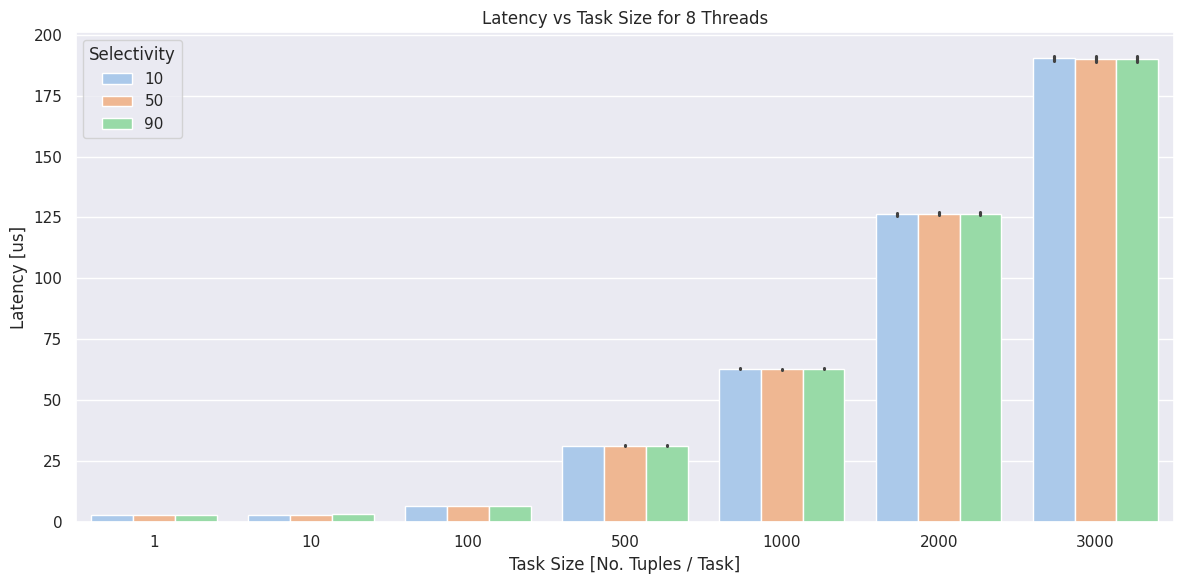

In [7]:
#df = load_data()
df = df[df['ProviderName'] == "Compilation"]


interesting_param = "NumberOfWorkerThreads"
x_param="NumberOfInputTuples"
y_params = ["TimeDifference"]
y_param_units = ["Latency [us]"]
hue="Selectivity"


unique_params = df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(12, 6), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = df[df[interesting_param] == param]  
    
    ax = axes[0][idx]
    sns.barplot(x=x_param, y=y_params[0], hue=hue, data=subset, ax=ax, palette="pastel")
    ax.set_title(f"Latency vs Task Size for {param} Threads")
    ax.set_xlabel("Task Size [No. Tuples / Task]")
    ax.set_ylabel(y_param_units[0])
    #ax.set_ylim([0, .04])

plt.tight_layout()
plt.savefig(os.path.join("/home/nils/Downloads", f"latency_vs_tasksize.pdf"))
plt.show()
plt.close()